In [1]:
from GeoGuesserSystem import *

In [2]:
BR = system_loader()

In [32]:
save_system(BR)

In [3]:
BR.train(1)

  1%|          | 49/4683 [00:42<1:07:29,  1.14it/s]


KeyboardInterrupt: 

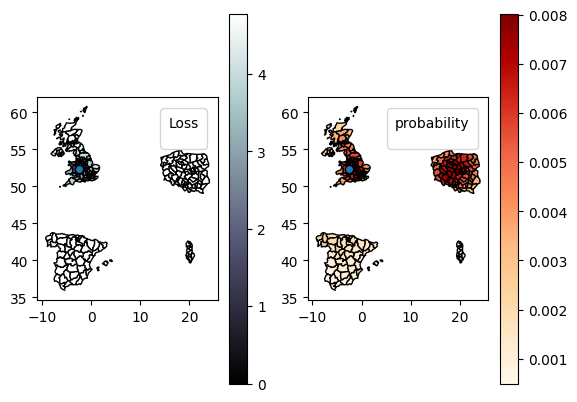

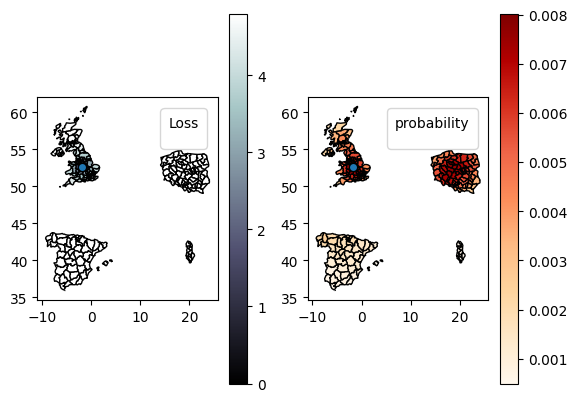

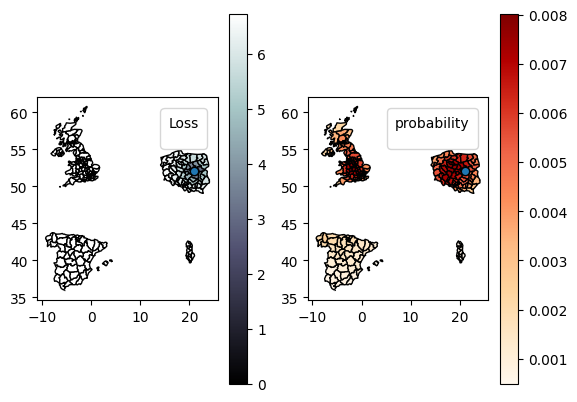

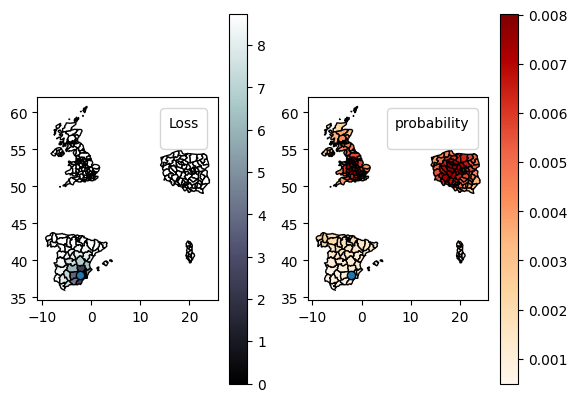

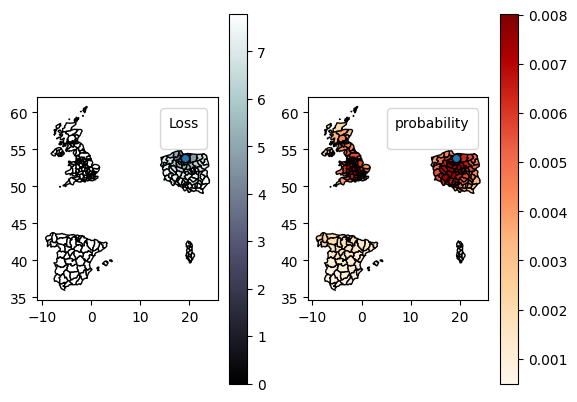

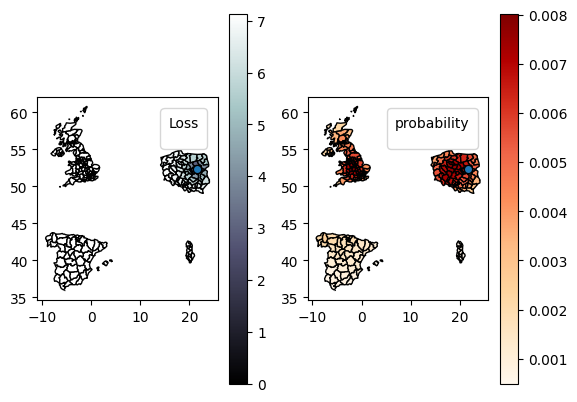

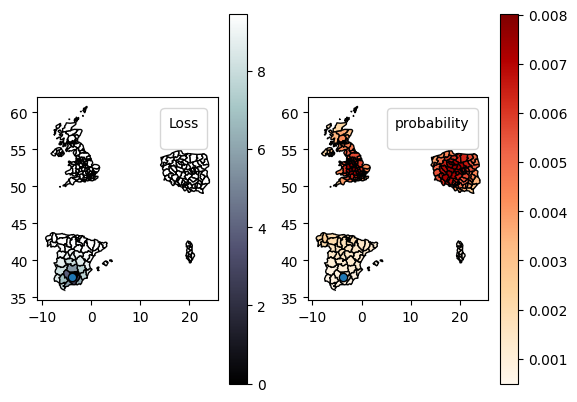

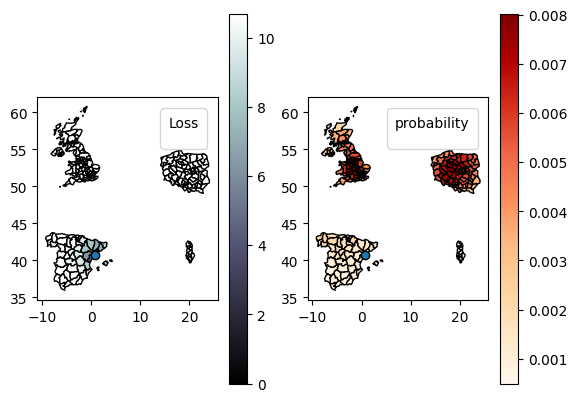

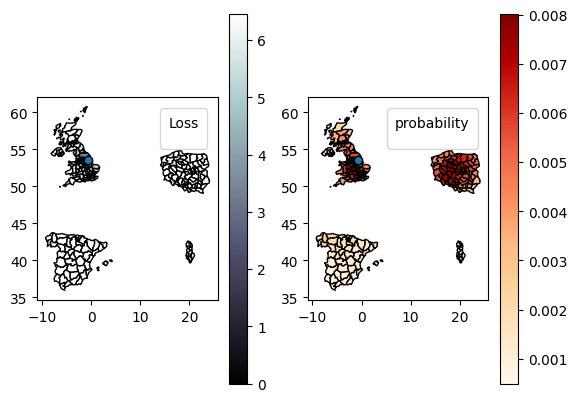

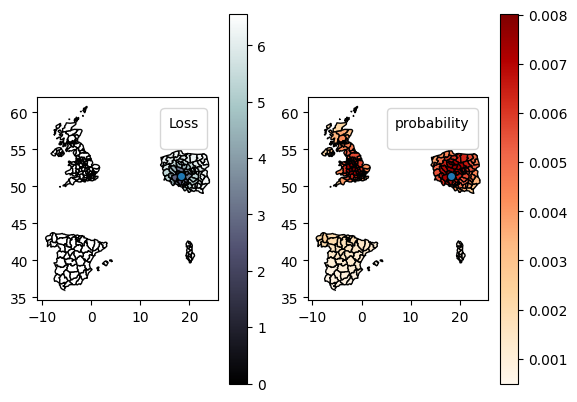

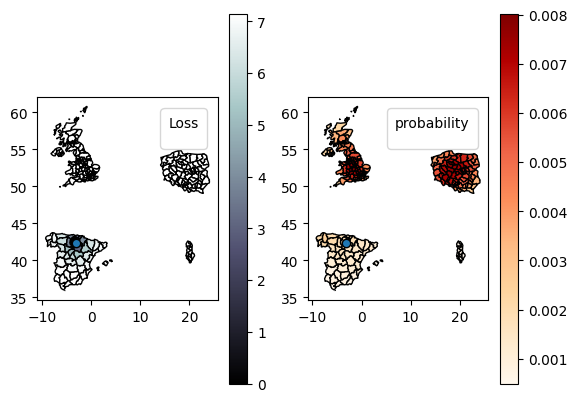

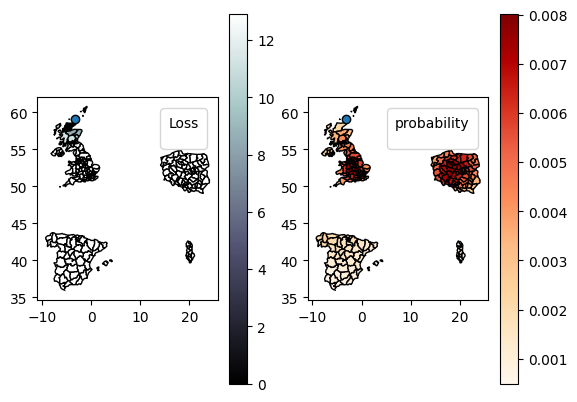

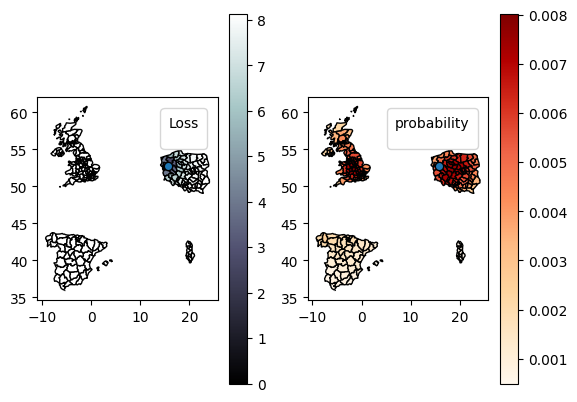

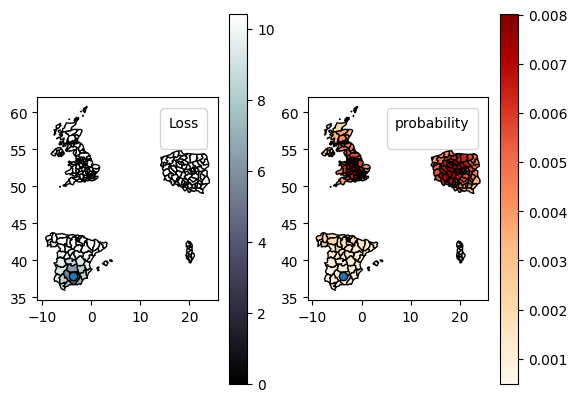

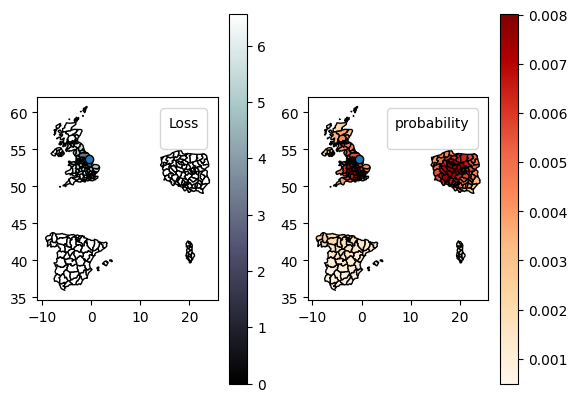

In [ ]:
loss_prop, gradient_analysis = BR.asses_photos(data=next(iter(BR.test_dataloader)))

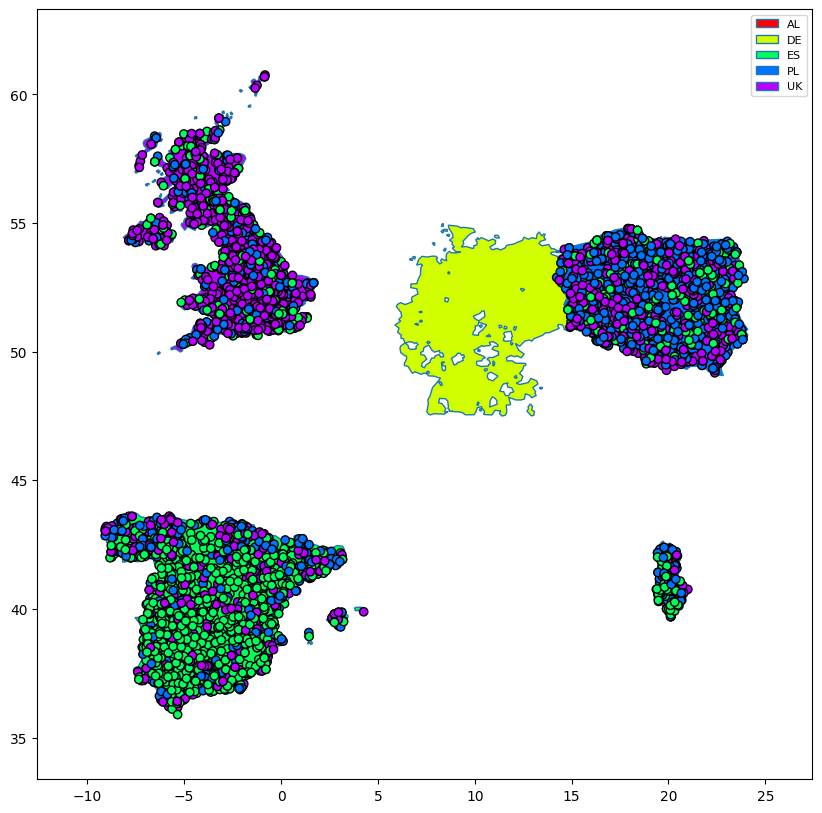

In [ ]:
occurences2, colors2, shp2, df12 = precision_level_set(BR.total_occurences, BR.shp, 1)
plot_predicted_points(shp2, colors2, occurences2, df12, BR.cords_list);